
# Sepsis 2019 — Predicción a 6 horas con ML clásico (LogReg vs HGB)

Notebook para entrenar **Logistic Regression**, **HistGradientBoosting** y **XGBoost** anticipando sepsis a **6 horas** con `SepsisLabel`.
Incluye *feature engineering* temporal (ventana 6h, deltas, time-since, flags de medición) y evaluación con **AUROC/AUPRC**.

**Columnas permitidas luego de análisis de caracteristicas**:  
`[
    'patient_id', 'SepsisLabel', 'ICULOS', 'Temp', 'Alkalinephos', 'BaseExcess',
    'Bilirubin_direct', 'Bilirubin_total', 'DBP',  'FiO2',  'Gender', 'Age',
    'HCO3', 'HR',  'HospAdmTime', 'Lactate', 'Magnesium', 'O2Sat', 'Resp', 'SaO2', 'TroponinI'
]`


## Requisitos

In [26]:
import numpy as np
import pandas as pd
from pathlib import Path
import os

import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature
import mlflow.xgboost
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score, roc_curve, precision_recall_curve, classification_report, auc,
    confusion_matrix, ConfusionMatrixDisplay, brier_score_loss, accuracy_score, precision_recall_fscore_support
)
from sklearn.calibration import calibration_curve
from sklearn.utils.class_weight import compute_class_weight
from joblib import dump
from joblib import Parallel, delayed

pd.options.display.max_columns = 200

## Configuración MLFlow

In [2]:
MLFLOW_TRACKING_URI = "http://54.88.49.152:8050/"
EXPERIMENT_NAME = "sepsis_challenge"

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)

<Experiment: artifact_location='mlflow-artifacts:/639501076581994165', creation_time=1756946861078, experiment_id='639501076581994165', last_update_time=1756946861078, lifecycle_stage='active', name='sepsis_challenge', tags={}>

## Métodos para presentar resultados de experimentos

In [37]:
RESULT_PATHS = "../results/artifacts"
os.makedirs(RESULT_PATHS, exist_ok=True)

def plot_and_log_curves(y_true, y_prob, run_prefix):
    # ROC
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure()
    plt.plot(fpr, tpr, lw=2)
    plt.plot([0,1],[0,1], linestyle="--")
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"ROC – {run_prefix}")
    roc_path = f"{RESULT_PATHS}/{run_prefix}_roc.png"
    plt.savefig(roc_path, bbox_inches="tight"); plt.close()
    mlflow.log_artifact(roc_path)

    # PR
    prec, rec, _ = precision_recall_curve(y_true, y_prob)
    plt.figure()
    plt.plot(rec, prec, lw=2)
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"PR – {run_prefix}")
    pr_path = f"{RESULT_PATHS}/{run_prefix}_pr.png"
    plt.savefig(pr_path, bbox_inches="tight"); plt.close()
    mlflow.log_artifact(pr_path)

    # Calibration
    frac_pos, mean_pred = calibration_curve(y_true, y_prob, n_bins=10, strategy="quantile")
    plt.figure()
    plt.plot(mean_pred, frac_pos, marker="o")
    plt.plot([0,1],[0,1], "--")
    plt.xlabel("Predicted probability"); plt.ylabel("Fraction of positives"); plt.title(f"Calibration – {run_prefix}")
    cal_path = f"{RESULT_PATHS}/{run_prefix}_calibration.png"
    plt.savefig(cal_path, bbox_inches="tight"); plt.close()
    mlflow.log_artifact(cal_path)

def log_confusion(y_true, y_prob, threshold, run_prefix):
    y_hat = (y_prob >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_hat, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    plt.figure()
    disp.plot(values_format="d")
    plt.title(f"Confusion Matrix @th={threshold:.3f} – {run_prefix}")
    cm_path = f"{RESULT_PATHS}/{run_prefix}_cm_{threshold:.3f}.png"
    plt.savefig(cm_path, bbox_inches="tight"); plt.close()
    mlflow.log_artifact(cm_path)

def best_threshold_fbeta(y_true, y_prob, beta=2.0):
    prec, rec, thr = precision_recall_curve(y_true, y_prob)  # thr len = len(prec)-1
    best_f, best_t = 0.0, 0.5
    b2 = beta**2
    for t in thr:
        y_hat = (y_prob >= t).astype(int)
        tp = ((y_hat == 1) & (y_true == 1)).sum()
        fp = ((y_hat == 1) & (y_true == 0)).sum()
        fn = ((y_hat == 0) & (y_true == 1)).sum()
        precision = tp / max(tp + fp, 1)
        recall = tp / max(tp + fn, 1)
        fbeta = (1+b2) * precision * recall / max(b2*precision + recall, 1e-12)
        if fbeta > best_f:
            best_f, best_t = fbeta, t
    return best_f, best_t

def metrics_block(y_true, y_prob, threshold):
    """Return AUROC, AUPRC, Accuracy@th, F2@th, plus also Accuracy@0.5 and F2@0.5 (for logging)."""
    auroc = roc_auc_score(y_true, y_prob)
    auprc = average_precision_score(y_true, y_prob)

    y_hat_thr = (y_prob >= threshold).astype(int)
    acc_thr = accuracy_score(y_true, y_hat_thr)

    # F2 @ threshold
    f2_thr, _ = best_threshold_fbeta(y_true, y_prob, beta=2.0)  # already computed elsewhere; safe here

    # Reference at 0.5
    y_hat_05 = (y_prob >= 0.5).astype(int)
    acc_05 = accuracy_score(y_true, y_hat_05)

    # F2 @ 0.5
    tp = ((y_hat_05 == 1) & (y_true == 1)).sum()
    fp = ((y_hat_05 == 1) & (y_true == 0)).sum()
    fn = ((y_hat_05 == 0) & (y_true == 1)).sum()
    precision_05 = tp / max(tp + fp, 1)
    recall_05 = tp / max(tp + fn, 1)
    b2 = 4.0
    f2_05 = (1+b2) * precision_05 * recall_05 / max(b2*precision_05 + recall_05, 1e-12)

    return {
        "auroc": auroc,
        "auprc": auprc,
        "acc_at_best_f2_thr": acc_thr,
        "f2_at_best_f2_thr": f2_thr,
        "acc_at_0_5": acc_05,
        "f2_at_0_5": f2_05
    }

## Configuración y carga de datos

In [15]:
DATA_DIR = Path("../data/raw")
FILE_A = DATA_DIR / "all_patients_setA.parquet"
FILE_B = DATA_DIR / "all_patients_setB.parquet"

assert FILE_A.exists(), f"No se encontró {FILE_A.resolve()}"
assert FILE_B.exists(), f"No se encontró {FILE_B.resolve()}"

allowed_cols = [
    'patient_id', 'SepsisLabel', 'ICULOS', 'Temp', 'Alkalinephos', 'BaseExcess',
    'Bilirubin_direct', 'Bilirubin_total', 'DBP',  'FiO2',  'Gender', 'Age',
    'HCO3', 'HR',  'HospAdmTime', 'Lactate', 'Magnesium', 'O2Sat', 'Resp', 'SaO2', 'TroponinI'
]

# Carga solo columnas disponibles en cada archivo
cols_a = [c for c in allowed_cols]
cols_b = [c for c in allowed_cols]
df_a = pd.read_parquet(FILE_A, columns=None)
df_b = pd.read_parquet(FILE_B, columns=None)
df_a = df_a[[c for c in allowed_cols if c in df_a.columns]]
df_b = df_b[[c for c in allowed_cols if c in df_b.columns]]
df = pd.concat([df_a, df_b], ignore_index=True)

print("Shape:", df.shape)
df.head()

Shape: (1552210, 21)


,patient_id,SepsisLabel,ICULOS,Temp,Alkalinephos,BaseExcess,Bilirubin_direct,Bilirubin_total,DBP,FiO2,Gender,Age,HCO3,HR,HospAdmTime,Lactate,Magnesium,O2Sat,Resp,SaO2,TroponinI
0,p000001,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,83.14,NaN,NaN,-0.03,NaN,NaN,NaN,NaN,NaN,NaN
1,p000001,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,83.14,NaN,97.0,-0.03,NaN,NaN,95.0,19.0,NaN,NaN
2,p000001,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,83.14,NaN,89.0,-0.03,NaN,NaN,99.0,22.0,NaN,NaN
3,p000001,0.0,4.0,NaN,NaN,24.0,NaN,NaN,NaN,NaN,0.0,83.14,NaN,90.0,-0.03,NaN,NaN,95.0,30.0,NaN,NaN
4,p000001,0.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,0.28,0.0,83.14,NaN,103.0,-0.03,NaN,NaN,88.5,24.5,NaN,NaN


In [5]:
nan_summary = (
    df.isna()
      .sum()
      .to_frame("NaN_count")
      .assign(NaN_percent=lambda d: d["NaN_count"] / len(df) * 100)
      .sort_values("NaN_percent", ascending=False)
)

nan_summary.head(50)

,NaN_count,NaN_percent
Bilirubin_direct,1549220,99.807371
TroponinI,1537429,99.047745
Bilirubin_total,1529069,98.509158
Alkalinephos,1527269,98.393194
Lactate,1510764,97.329872
SaO2,1498649,96.549372
HCO3,1487182,95.810618
BaseExcess,1468065,94.579020
Magnesium,1454259,93.689578
FiO2,1422845,91.665754


In [6]:
threshold = 0.96
base_feats = df.columns[df.isna().mean() <= threshold].tolist()
print("Columnas selecionadas:", base_feats)
df = df.loc[:, df.isna().mean() <= threshold]

Columnas selecionadas: ['patient_id', 'SepsisLabel', 'ICULOS', 'Temp', 'BaseExcess', 'DBP', 'FiO2', 'Gender', 'Age', 'HCO3', 'HR', 'HospAdmTime', 'Magnesium', 'O2Sat', 'Resp']


## Feature engineering temporal (rolling, deltas, time-since, flags)

In [7]:
id_col = "patient_id"
t_col  = "ICULOS"
y_col  = "SepsisLabel"
categoric = 'Gender'
base_feats = [c for c in base_feats if c not in [id_col, t_col, y_col, categoric]]

# ====== Máscara de faltantes por variable (se conserva como feature opcional) ======
for c in base_feats:
    df[c + "_isna"] = df[c].isna().astype("int8")  # usar df original antes del ffill

# ====== Forward-fill por paciente ======
df_ff = df.copy()
df_ff[base_feats] = df.groupby(id_col, group_keys=False)[base_feats].ffill()

# ====== Definir estratos poblacionales ======
strata = []
# Usa Gender si existe
if "Gender" in df.columns:
    # asegúrate que sea categórica
    df_ff["Gender"] = df_ff["Gender"].astype("category")
    strata.append("Gender")

# Crear banda de edad si 'Age' existe (clínicamente razonable)
if "Age" in df.columns:
    # Ajusta cortes si prefieres otros límites
    df_ff["AgeBand"] = pd.cut(df_ff["Age"].astype("float32"),
                              bins=[-np.inf, 30, 50, 70, np.inf],
                              labels=["<=30","31-50","51-70",">70"])
    strata.append("AgeBand")

# Si no hay estratos disponibles, no fallar: usa lista vacía (equivale a mediana global)
# Imputación estratificada + fallback global
global_medians = df[base_feats].median()

if len(strata) > 0:
    grp = df_ff.groupby(strata, observed=True)  # observed=True evita combinaciones vacías
    for c in base_feats:
        # mediana por estrato
        med_strata = grp[c].transform("median")
        # rellenar: primero por estrato, luego con mediana global
        df_ff[c] = df_ff[c].fillna(med_strata)
        df_ff[c] = df_ff[c].fillna(global_medians[c]).astype("float32")
else:
    # sin estratos, solo fallback global
    df_ff[base_feats] = df_ff[base_feats].fillna(global_medians.astype("float32")).astype("float32")

In [8]:
nan_summary = (
    df_ff.isna()
      .sum()
      .to_frame("NaN_count")
      .assign(NaN_percent=lambda d: d["NaN_count"] / len(df) * 100)
      .sort_values("NaN_percent", ascending=False)
)

nan_summary.head(50)

,NaN_count,NaN_percent
patient_id,0,0.0
Resp,0,0.0
Resp_isna,0,0.0
O2Sat_isna,0,0.0
Magnesium_isna,0,0.0
HospAdmTime_isna,0,0.0
HR_isna,0,0.0
HCO3_isna,0,0.0
Age_isna,0,0.0
FiO2_isna,0,0.0


In [9]:
# Parámetros
WINDOWS = [3, 6]          
STATS   = ["mean", "std"]     
PAIRS   = [(3, 6)]            
SLOPES  = [3, 6]              # slopes esenciales
EPS     = 1e-6

pd.options.mode.copy_on_write = True

# --- Categóricas
cat_feats = [c for c in ["Gender"] if c in df_ff.columns]
if cat_feats:
    for c in cat_feats:
        df_ff[c] = df_ff[c].astype("category")

# --- BLOQUES DE FEATURES ---
blocks = []

# 1) Rolling mean/std por ventana para TODAS las columnas a la vez
gb = df_ff.groupby(id_col)[base_feats]
for w in WINDOWS:
    # mean
    mean_w = gb.rolling(window=w, min_periods=1).mean().reset_index(level=0, drop=True)
    mean_w.columns = [f"{c}_mean_{w}h" for c in base_feats]
    mean_w = mean_w.astype("float32")
    blocks.append(mean_w)

    # std (min_periods=2 si w>1)
    if "std" in STATS:
        minp = 2 if w > 1 else 1
        std_w = gb.rolling(window=w, min_periods=minp).std(ddof=1).reset_index(level=0, drop=True)
        std_w.columns = [f"{c}_std_{w}h" for c in base_feats]
        std_w = std_w.astype("float32")
        blocks.append(std_w)

# 2) Slopes (diff/w) para todas las columnas a la vez
slope_blocks = []
for w in SLOPES:
    sl = gb.diff(w) / float(w)
    sl.columns = [f"{c}_slope_{w}h" for c in base_feats]
    slope_blocks.append(sl.astype("float32"))
if slope_blocks:
    blocks.append(pd.concat(slope_blocks, axis=1))

# 3) Tiempo desde última muestra real (tsince) -> construir dict y DataFrame de una
tsince_dict = {}
for c in base_feats:
    last_t = df_ff[t_col].where(df_ff[c].notna())
    last_t_ff = last_t.groupby(df_ff[id_col]).ffill()
    tsince_dict[f"{c}_tsince"] = (df_ff[t_col] - last_t_ff).fillna(1e9).astype("float32")
blocks.append(pd.DataFrame(tsince_dict, index=df_ff.index))

# Unir todos los bloques (evita fragmentación)
features_df = pd.concat(blocks, axis=1)

# 4) Comparaciones entre ventanas (solo mean 1 vs 6) en UN BLOQUE
pair_dict = {}
for c in base_feats:
    a, b = PAIRS[0]
    ca = f"{c}_mean_{a}h"
    cb = f"{c}_mean_{b}h"
    pair_dict[f"{c}_mean_{a}v{b}_diff"]  = (features_df[ca] - features_df[cb]).astype("float32")
    pair_dict[f"{c}_mean_{a}v{b}_ratio"] = (features_df[ca] / (features_df[cb].abs() + EPS)).astype("float32")
pair_df = pd.DataFrame(pair_dict, index=df_ff.index)
features_df = pd.concat([features_df, pair_df], axis=1)

# 5) Índices fisiológicos (en bloque)
idx = {}
if {"HR", "SBP"}.issubset(df_ff.columns):
    idx["shock_index"] = (df_ff["HR"] / (df_ff["SBP"] + EPS)).astype("float32")
if {"HR", "MAP"}.issubset(df_ff.columns):
    idx["msi"] = (df_ff["HR"] / (df_ff["MAP"] + EPS)).astype("float32")
if "FiO2" in df_ff.columns:
    fi_frac = np.where(df_ff["FiO2"] > 1, df_ff["FiO2"] / 100.0, df_ff["FiO2"]).astype("float32")
    df_ff["FiO2_frac"] = fi_frac
if {"O2Sat", "FiO2_frac"}.issubset(df_ff.columns):
    idx["s_f_ratio"] = (df_ff["O2Sat"] / (df_ff["FiO2_frac"] + EPS)).astype("float32")
if {"O2Sat","FiO2_frac","Resp"}.issubset(df_ff.columns):
    idx["rox_index"] = (df_ff["O2Sat"] / (df_ff["FiO2_frac"] + EPS) / (df_ff["Resp"] + EPS)).astype("float32")

if idx:
    features_df = pd.concat([features_df, pd.DataFrame(idx, index=df_ff.index)], axis=1)

# 6) One-hot categóricas (bloque)
df_cat = (pd.get_dummies(df_ff[cat_feats], drop_first=True, dtype="int8")
          if cat_feats else pd.DataFrame(index=df_ff.index))

# 7) X final (una sola concatenación + copy para “defragmentar”)
X_df = pd.concat([features_df, df_cat], axis=1).copy()
print("Total features:", X_df.shape[1])

Total features: 102


In [10]:
nan_summary = (
    X_df.isna()
      .sum()
      .to_frame("NaN_count")
      .assign(NaN_percent=lambda d: d["NaN_count"] / len(df) * 100)
      .sort_values("NaN_percent", ascending=False)
)

nan_summary.head(50)

,NaN_count,NaN_percent
Age_slope_6h,242016,15.591705
Resp_slope_6h,242016,15.591705
O2Sat_slope_6h,242016,15.591705
Magnesium_slope_6h,242016,15.591705
HospAdmTime_slope_6h,242016,15.591705
HR_slope_6h,242016,15.591705
HCO3_slope_6h,242016,15.591705
FiO2_slope_6h,242016,15.591705
DBP_slope_6h,242016,15.591705
BaseExcess_slope_6h,242016,15.591705


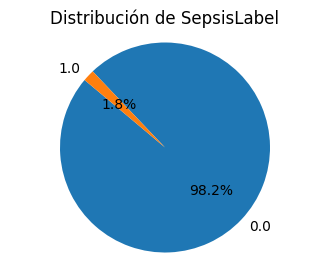

In [11]:
sepsis_counts = df['SepsisLabel'].value_counts()
plt.figure(figsize=(4, 3))
plt.pie(sepsis_counts, labels=sepsis_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribución de SepsisLabel')
plt.axis('equal')
plt.show()

## Divison por paciente con y sin preprocesamiento

In [12]:
X_df.head(30)

,Temp_mean_3h,BaseExcess_mean_3h,DBP_mean_3h,FiO2_mean_3h,Age_mean_3h,HCO3_mean_3h,HR_mean_3h,HospAdmTime_mean_3h,Magnesium_mean_3h,O2Sat_mean_3h,Resp_mean_3h,Temp_std_3h,BaseExcess_std_3h,DBP_std_3h,FiO2_std_3h,Age_std_3h,HCO3_std_3h,HR_std_3h,HospAdmTime_std_3h,Magnesium_std_3h,O2Sat_std_3h,Resp_std_3h,Temp_mean_6h,BaseExcess_mean_6h,DBP_mean_6h,FiO2_mean_6h,Age_mean_6h,HCO3_mean_6h,HR_mean_6h,HospAdmTime_mean_6h,Magnesium_mean_6h,O2Sat_mean_6h,Resp_mean_6h,Temp_std_6h,BaseExcess_std_6h,DBP_std_6h,FiO2_std_6h,Age_std_6h,HCO3_std_6h,HR_std_6h,HospAdmTime_std_6h,Magnesium_std_6h,O2Sat_std_6h,Resp_std_6h,Temp_slope_3h,BaseExcess_slope_3h,DBP_slope_3h,FiO2_slope_3h,Age_slope_3h,HCO3_slope_3h,HR_slope_3h,HospAdmTime_slope_3h,Magnesium_slope_3h,O2Sat_slope_3h,Resp_slope_3h,Temp_slope_6h,BaseExcess_slope_6h,DBP_slope_6h,FiO2_slope_6h,Age_slope_6h,HCO3_slope_6h,HR_slope_6h,HospAdmTime_slope_6h,Magnesium_slope_6h,O2Sat_slope_6h,Resp_slope_6h,Temp_tsince,BaseExcess_tsince,DBP_tsince,FiO2_tsince,Age_tsince,HCO3_tsince,HR_tsince,HospAdmTime_tsince,Magnesium_tsince,O2Sat_tsince,Resp_tsince,Temp_mean_3v6_diff,Temp_mean_3v6_ratio,BaseExcess_mean_3v6_diff,BaseExcess_mean_3v6_ratio,DBP_mean_3v6_diff,DBP_mean_3v6_ratio,FiO2_mean_3v6_diff,FiO2_mean_3v6_ratio,Age_mean_3v6_diff,Age_mean_3v6_ratio,HCO3_mean_3v6_diff,HCO3_mean_3v6_ratio,HR_mean_3v6_diff,HR_mean_3v6_ratio,HospAdmTime_mean_3v6_diff,HospAdmTime_mean_3v6_ratio,Magnesium_mean_3v6_diff,Magnesium_mean_3v6_ratio,O2Sat_mean_3v6_diff,O2Sat_mean_3v6_ratio,Resp_mean_3v6_diff,Resp_mean_3v6_ratio,s_f_ratio,rox_index,Gender_1.0
0,36.779999,0.000000,58.0,0.40,83.139999,24.0,81.000000,-0.03,2.0,98.000000,18.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.779999,0.000000,58.0,0.400,83.139999,24.0,81.000000,-0.03,2.0,98.000000,18.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,0.000000,0.0,1.0,0.000,0.999997,0.0,1.0,0.0,1.000000,0.000000,1.000000,0.0,-0.999967,0.0,1.0,0.000000,1.000000,0.000000,1.000000,244.999374,13.611074,0
1,36.779999,0.000000,58.0,0.40,83.139999,24.0,89.000000,-0.03,2.0,96.500000,18.500000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,11.313708,0.0,0.0,2.121320,0.707107,36.779999,0.000000,58.0,0.400,83.139999,24.0,89.000000,-0.03,2.0,96.500000,18.500000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,11.313708,0.0,0.0,2.121320,0.707107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,0.000000,0.0,1.0,0.000,0.999997,0.0,1.0,0.0,1.000000,0.000000,1.000000,0.0,-0.999967,0.0,1.0,0.000000,1.000000,0.000000,1.000000,237.499390,12.499967,0
2,36.779999,0.000000,58.0,0.40,83.139999,24.0,89.000000,-0.03,2.0,97.333336,19.666666,0.000000,0.000000,0.0,0.000000,0.0,0.000000,8.000000,0.0,0.0,2.081666,2.081666,36.779999,0.000000,58.0,0.400,83.139999,24.0,89.000000,-0.03,2.0,97.333336,19.666666,0.000000,0.000000,0.0,0.000000,0.0,0.000000,8.000000,0.0,0.0,2.081666,2.081666,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,0.000000,0.0,1.0,0.000,0.999997,0.0,1.0,0.0,1.000000,0.000000,1.000000,0.0,-0.999967,0.0,1.0,0.000000,1.000000,0.000000,1.000000,247.499374,11.249970,0
3,36.779999,8.000000,58.0,0.40,83.139999,24.0,92.000000,-0.03,2.0,96.333336,23.666666,0.000000,13.856406,0.0,0.000000,0.0,0.000000,4.358899,0.0,0.0,2.309401,5.686241,36.779999,6.000000,58.0,0.400,83.139999,24.0,89.250000,-0.03,2.0,96.750000,22.250000,0.000000,12.000000,0.0,0.000000,0.0,0.000000,6.551081,0.0,0.0,2.061553,5.439056,0.000000,8.000000,0.0,0.00,0.0,0.0,3.000000,0.0,0.0,-1.000000,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,2.000000,1.333333,0.0,1.0,0.000,0.999997,0.0,1.0,0.0,1

In [13]:
y = df[y_col].astype(int).values
groups = df[id_col].values
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, valid_idx = next(gss.split(X_df, y, groups=groups))

X_train_df = X_df.iloc[train_idx]
y_train    = y[train_idx]
X_valid_df = X_df.iloc[valid_idx]
y_valid    = y[valid_idx]

print("Prev train:", y_train.mean(), "| Prev valid:", y_valid.mean())
X_train_df.shape, X_valid_df.shape


Prev train: 0.01826358570205114 | Prev valid: 0.016871545384682166


((1241213, 102), (310997, 102))

### División para HGB y XGBoost

In [19]:
y = df[y_col].astype(int).values
x_df = df.drop(columns=[y_col, id_col])

groups = df[id_col].values
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, valid_idx = next(gss.split(x_df, y, groups=groups))

X_train_clean = x_df.iloc[train_idx]
y_train_clean = y[train_idx]
X_valid_clean = x_df.iloc[valid_idx]
y_valid_clean = y[valid_idx]

print("Prev train:", y_train_clean.mean(), "| Prev valid:", y_valid_clean.mean())
X_train_clean.shape, X_valid_clean.shape

Prev train: 0.01826358570205114 | Prev valid: 0.016871545384682166


((1241213, 19), (310997, 19))

## Entrenamiento y evaluación

In [37]:
# Logistic Regression
pipe_lr = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False)),
    ("clf", LogisticRegression(max_iter=3500, class_weight="balanced",n_jobs=-1))
])

with mlflow.start_run(run_name="LR_balanced"):
    # Tags to organize in your IA/master projector
    mlflow.set_tags({
        "project": "DesarrolloSoluciones",
        "component": "sepsis_6h",
        "model_family": "LogisticRegression",
        "dataset": "physionet2019",
        "split": "train/valid",
        "owner": "deayala"
    })
    pipe_lr.fit(X_train_df, y_train)
    p_lr = pipe_lr.predict_proba(X_valid_df)[:,1]

    # choose best threshold by F2
    f2_lr, thr_lr = best_threshold_fbeta(y_valid, p_lr, beta=2.0)

    # compute & log metrics
    block = metrics_block(y_valid, p_lr, threshold=thr_lr)
    mlflow.log_params({
        "imp_strategy": "median",
        "scaler_with_mean": False,
        "clf_max_iter": 3500,
        "clf_class_weight": "balanced",
        "clf_n_jobs": -1
    })
    mlflow.log_metrics({
        "valid_auroc": block["auroc"],
        "valid_auprc": block["auprc"],
        "valid_accuracy_at_bestF2thr": block["acc_at_best_f2_thr"],
        "valid_f2_at_bestF2thr": block["f2_at_best_f2_thr"],
        "valid_accuracy_at_0.5": block["acc_at_0_5"],
        "valid_f2_at_0.5": block["f2_at_0_5"],
        "valid_best_threshold_F2": float(thr_lr),
        "n_train": int(len(y_train)),
        "n_valid": int(len(y_valid))
    })

    # extras (optional visuals)
    plot_and_log_curves(y_valid, p_lr, run_prefix="LR")
    log_confusion(y_valid, p_lr, threshold=thr_lr, run_prefix="LR")

    # log model
    mlflow.sklearn.log_model(pipe_lr, name="model")

    print(f"[LR] AUROC={block['auroc']:.4f} | AUPRC={block['auprc']:.4f} | "
          f"ACC@bestF2={block['acc_at_best_f2_thr']:.4f} | F2@bestF2={block['f2_at_best_f2_thr']:.4f} "
          f"(thr={thr_lr:.3f}) | ACC@0.5={block['acc_at_0_5']:.4f} | F2@0.5={block['f2_at_0_5']:.4f}")

2025/09/06 22:08:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[LR] AUROC=0.6632 | AUPRC=0.0403 | ACC@bestF2=0.8798 | F2@bestF2=0.1475 (thr=0.611) | ACC@0.5=0.6785 | F2@0.5=0.1222
🏃 View run LR_balanced at: http://52.90.140.176:8050/#/experiments/639501076581994165/runs/fe72954467b64dd4ab6fa628e06543e2
🧪 View experiment at: http://52.90.140.176:8050/#/experiments/639501076581994165


<Figure size 640x480 with 0 Axes>

In [20]:
# HGB
classes = np.array([0,1])
cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_train_clean)
class_weight = {0: cw[0], 1: cw[1]}

hgb_params = dict(
    learning_rate=0.05,
    max_iter=1000,

    max_leaf_nodes=80,          
    min_samples_leaf=60,        

    l2_regularization=1.0,                 

    class_weight=class_weight,
    early_stopping=True,
    validation_fraction=0.2,   
    n_iter_no_change=80,        
    scoring="average_precision",

    random_state=42
)

hgb = HistGradientBoostingClassifier(**hgb_params)

with mlflow.start_run(run_name="HGB_weighted"):
    mlflow.set_tags({
        "project": "DesarrolloSoluciones",
        "component": "sepsis_6h",
        "model_family": "HistGradientBoosting",
        "dataset": "physionet2019",
        "split": "train/valid",
        "owner": "deayala"
    })
    
    hgb.fit(X_train_clean, y_train_clean)
    p_hgb = hgb.predict_proba(X_valid_clean)[:,1]

    # best threshold by F2
    f2_hgb, thr_hgb = best_threshold_fbeta(y_valid_clean, p_hgb, beta=2.0)

    # compute & log metrics
    block = metrics_block(y_valid_clean, p_hgb, threshold=thr_hgb)
    mlflow.log_params({
        **hgb_params,
        "reweighting": "class_weight -> sample_weight",
        "cw_pos": class_weight[1],
        "cw_neg": class_weight[0]
    })
    mlflow.log_metrics({
        "valid_auroc": block["auroc"],
        "valid_auprc": block["auprc"],
        "valid_accuracy_at_bestF2thr": block["acc_at_best_f2_thr"],
        "valid_f2_at_bestF2thr": block["f2_at_best_f2_thr"],
        "valid_accuracy_at_0.5": block["acc_at_0_5"],
        "valid_f2_at_0.5": block["f2_at_0_5"],
        "valid_best_threshold_F2": float(thr_hgb),
        "n_train": int(len(y_train)),
        "n_valid": int(len(y_valid))
    })

    plot_and_log_curves(y_valid_clean, p_hgb, run_prefix="HGB")
    log_confusion(y_valid_clean, p_hgb, threshold=thr_hgb, run_prefix="HGB")

    signature = infer_signature(X_train_clean, hgb.predict(X_train_clean))

    # Choose one row as input example
    input_example = X_train_clean.iloc[:1]
    mlflow.sklearn.log_model(hgb, name="model", signature=signature, input_example=input_example)

    print(f"[HGB] AUROC={block['auroc']:.4f} | AUPRC={block['auprc']:.4f} | "
          f"ACC@bestF2={block['acc_at_best_f2_thr']:.4f} | F2@bestF2={block['f2_at_best_f2_thr']:.4f} "
          f"(thr={thr_hgb:.3f}) | ACC@0.5={block['acc_at_0_5']:.4f} | F2@0.5={block['f2_at_0_5']:.4f}")

[HGB] AUROC=0.7578 | AUPRC=0.0746 | ACC@bestF2=0.9165 | F2@bestF2=0.2193 (thr=0.545) | ACC@0.5=0.8999 | F2@0.5=0.2166
🏃 View run HGB_weighted at: http://54.88.49.152:8050/#/experiments/639501076581994165/runs/6f926bf29d854d1ebd0c3b71d25a6c96
🧪 View experiment at: http://54.88.49.152:8050/#/experiments/639501076581994165


<Figure size 640x480 with 0 Axes>

In [33]:
# XGB
classes = np.array([0, 1])
cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_train_clean)
class_weight = {0: float(cw[0]), 1: float(cw[1])}

# (Optional) native alt: scale_pos_weight = (neg/pos) — if you prefer XGB’s built-in balancing
spw = (y_train_clean == 0).sum() / max((y_train_clean == 1).sum(), 1)

xgb_params = dict(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=80,
    min_child_weight=30,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,         
    scale_pos_weight=spw,  
    objective="binary:logistic",
    eval_metric="aucpr",     # optimize PR AUC during early stopping
    tree_method="hist",
    n_jobs=-1,
    random_state=42
)

xgb = XGBClassifier(**xgb_params)

with mlflow.start_run(run_name="XGB_weighted"):
    mlflow.set_tags({
        "project": "DesarrolloSoluciones",
        "component": "sepsis_6h",
        "model_family": "XGBoost",
        "dataset": "physionet2019",
        "split": "train/valid",
        "owner": "deayala"
    })

    # Fit with early stopping on the validation set
    xgb.fit(
        X_train_clean, y_train_clean,
        eval_set=[(X_valid_clean, y_valid_clean)],
        verbose=False
    )

    p_xgb = xgb.predict_proba(X_valid_clean)[:, 1]

    # Best threshold by F2
    f2_xgb, thr_xgb = best_threshold_fbeta(y_valid_clean, p_xgb, beta=2.0)

    # Compute & log metrics
    block = metrics_block(y_valid_clean, p_xgb, threshold=thr_xgb)

    mlflow.log_params({
        **{f"xgb__{k}": v for k, v in xgb_params.items() if k != "eval_metric"},
        "eval_metric": "aucpr",
        "reweighting": "class_weight -> sample_weight",
        "cw_pos": class_weight[1],
        "cw_neg": class_weight[0],
        # ,"scale_pos_weight": float(spw)   # if you enable it
    })

    mlflow.log_metrics({
        "valid_auroc": block["auroc"],
        "valid_auprc": block["auprc"],
        "valid_accuracy_at_bestF2thr": block["acc_at_best_f2_thr"],
        "valid_f2_at_bestF2thr": block["f2_at_best_f2_thr"],
        "valid_accuracy_at_0.5": block["acc_at_0_5"],
        "valid_f2_at_0.5": block["f2_at_0_5"],
        "valid_best_threshold_F2": float(thr_xgb),
        "n_train": int(len(y_train_clean)),
        "n_valid": int(len(y_valid_clean))
    })

    plot_and_log_curves(y_valid_clean, p_xgb, run_prefix="XGB")
    log_confusion(y_valid_clean, p_xgb, threshold=thr_xgb, run_prefix="XGB")

    # Model signature + logging
    signature = infer_signature(X_train_clean, xgb.predict(X_train_clean))
    input_example = X_train_clean.iloc[:1]
    mlflow.xgboost.log_model(
        xgb, artifact_path="model",
        signature=signature,
        input_example=input_example
    )

    print(f"[XGB] AUROC={block['auroc']:.4f} | AUPRC={block['auprc']:.4f} | "
          f"ACC@bestF2={block['acc_at_best_f2_thr']:.4f} | F2@bestF2={block['f2_at_best_f2_thr']:.4f} "
          f"(thr={thr_xgb:.3f}) | ACC@0.5={block['acc_at_0_5']:.4f} | F2@0.5={block['f2_at_0_5']:.4f}")

2025/09/07 08:24:18 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/Users/danielayala/Documents/Daniel Ayala/Study/MaIA/DesarrolloSoluciones/Microproyecto/physionet-sepsis-forecasting/venv/lib/python3.12/site-packages/xgboost/sklearn.py:1028: UserWarning: [08:24:20] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)


[XGB] AUROC=0.7421 | AUPRC=0.0619 | ACC@bestF2=0.9085 | F2@bestF2=0.1961 (thr=0.048) | ACC@0.5=0.9701 | F2@0.5=0.1160
🏃 View run XGB_weighted at: http://54.88.49.152:8050/#/experiments/639501076581994165/runs/769c48272ae2484486ba9ee59e2c1a0a
🧪 View experiment at: http://54.88.49.152:8050/#/experiments/639501076581994165


<Figure size 640x480 with 0 Axes>

## Curvas Precision-Recall

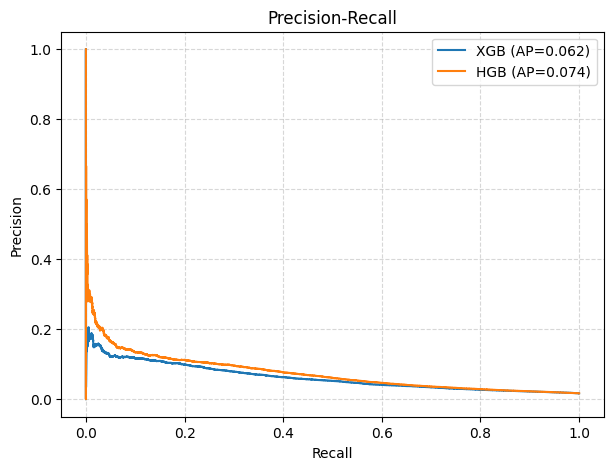

In [34]:
def plot_pr(y_true, scores_dict):
    plt.figure(figsize=(7,5))
    for name, s in scores_dict.items():
        p, r, _ = precision_recall_curve(y_true, s)
        ap = auc(r, p)
        plt.plot(r, p, label=f"{name} (AP={ap:.3f})")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall")
    plt.legend(); plt.grid(True, linestyle="--", alpha=0.5); plt.show()

#plot_pr(y_valid, {"LogReg": p_lr, "HGB": p_hgb})
plot_pr(y_valid, {"XGB": p_xgb, "HGB": p_hgb})

## Búsqueda de umbral (F2)

In [35]:
def report_at_threshold(y_true, y_prob, thr=0.5, name="model"):
    y_pred = (y_prob >= thr).astype(int)
    print(f"\n{name} @ threshold={thr:.2f}")
    print(classification_report(y_true, y_pred, digits=3))

#report_at_threshold(y_valid, p_lr, thr=0.5, name="LogReg")
report_at_threshold(y_valid, p_hgb, thr=0.5, name="HGB")
report_at_threshold(y_valid, p_xgb, thr=0.5, name="XGB")


HGB @ threshold=0.50
              precision    recall  f1-score   support

           0      0.989     0.908     0.947    305750
           1      0.073     0.424     0.125      5247

    accuracy                          0.900    310997
   macro avg      0.531     0.666     0.536    310997
weighted avg      0.974     0.900     0.933    310997


XGB @ threshold=0.50
              precision    recall  f1-score   support

           0      0.985     0.985     0.985    305750
           1      0.116     0.116     0.116      5247

    accuracy                          0.970    310997
   macro avg      0.550     0.550     0.550    310997
weighted avg      0.970     0.970     0.970    310997



In [31]:
def sweep_threshold(y_true, y_prob, beta=2.0):
    ths = np.linspace(0.0, 1.0, 101)
    rows = []
    for t in ths:
        y_pred = (y_prob >= t).astype(int)
        p, r, f, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0, beta=beta)
        rows.append((t, p, r, f))
    out = pd.DataFrame(rows, columns=["thr","precision","recall","Fbeta"])
    return out.sort_values("Fbeta", ascending=False).head(10)

#print("Top F2 — LogReg:\n", sweep_threshold(y_valid, p_lr, beta=2.0))
print("Top F2 — HGB:\n", sweep_threshold(y_valid, p_hgb, beta=2.0))
print("Top F2 — XGB:\n", sweep_threshold(y_valid, p_xgb, beta=2.0))

Top F2 — HGB:
      thr  precision    recall     Fbeta
57  0.57   0.085169  0.359634  0.218686
54  0.54   0.079957  0.385935  0.218616
53  0.53   0.078283  0.394892  0.218307
58  0.58   0.086922  0.350867  0.218293
55  0.55   0.081356  0.375643  0.217959
56  0.56   0.083060  0.366495  0.217830
51  0.51   0.074878  0.413951  0.217222
59  0.59   0.088200  0.340766  0.216675
52  0.52   0.076156  0.401944  0.216614
50  0.50   0.073287  0.423671  0.216578
Top F2 — XGB:
      thr  precision    recall     Fbeta
3   0.03   0.067937  0.368973  0.195615
4   0.04   0.072418  0.336764  0.194655
5   0.05   0.075927  0.313894  0.192948
2   0.02   0.061432  0.414713  0.192877
6   0.06   0.078668  0.295407  0.190460
7   0.07   0.081153  0.280732  0.188175
8   0.08   0.084004  0.270631  0.187375
9   0.09   0.086871  0.262436  0.186894
10  0.10   0.088878  0.253288  0.184886
11  0.11   0.090454  0.244521  0.182389


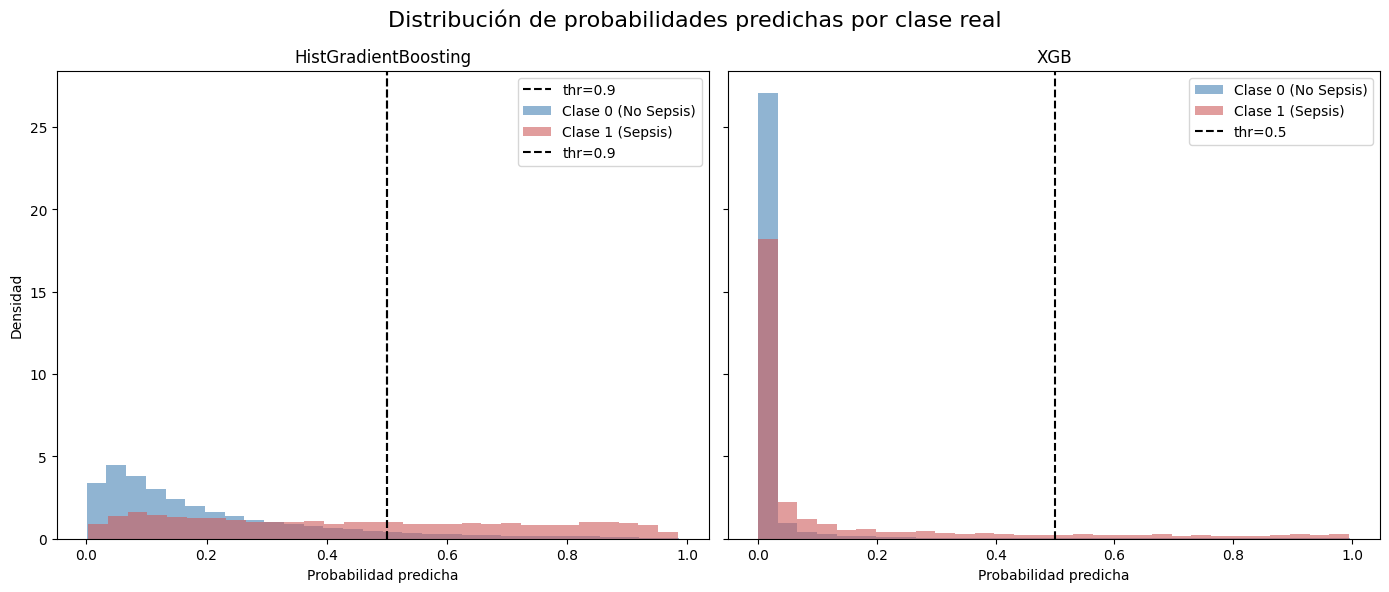

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=True)

# -------- LogReg --------
#probas_pos_lr = p_lr[y_valid == 1]
#probas_neg_lr = p_lr[y_valid == 0]

#axes[0].hist(probas_neg_lr, bins=30, alpha=0.6, label="Clase 0 (No Sepsis)", color="steelblue", density=True)
#axes[0].hist(probas_pos_lr, bins=30, alpha=0.6, label="Clase 1 (Sepsis)", color="indianred", density=True)
axes[0].axvline(0.5, color="black", linestyle="--", label="thr=0.9")
axes[0].set_title("Logistic Regression")
axes[0].set_xlabel("Probabilidad predicha")
axes[0].set_ylabel("Densidad")
axes[0].legend()

# -------- HGB --------
probas_pos_hgb = p_hgb[y_valid == 1]
probas_neg_hgb = p_hgb[y_valid == 0]

axes[0].hist(probas_neg_hgb, bins=30, alpha=0.6, label="Clase 0 (No Sepsis)", color="steelblue", density=True)
axes[0].hist(probas_pos_hgb, bins=30, alpha=0.6, label="Clase 1 (Sepsis)", color="indianred", density=True)
axes[0].axvline(0.5, color="black", linestyle="--", label="thr=0.9")
axes[0].set_title("HistGradientBoosting")
axes[0].set_xlabel("Probabilidad predicha")
axes[0].legend()

# -------- XGB --------
probas_pos_xgb = p_xgb[y_valid == 1]
probas_neg_xgb = p_xgb[y_valid == 0]

axes[1].hist(probas_neg_xgb, bins=30, alpha=0.6, label="Clase 0 (No Sepsis)", color="steelblue", density=True)
axes[1].hist(probas_pos_xgb, bins=30, alpha=0.6, label="Clase 1 (Sepsis)", color="indianred", density=True)
axes[1].axvline(0.5, color="black", linestyle="--", label="thr=0.5")
axes[1].set_title("XGB")
axes[1].set_xlabel("Probabilidad predicha")
axes[1].legend()

plt.suptitle("Distribución de probabilidades predichas por clase real", fontsize=16)
plt.tight_layout()
plt.show()

## Guardar modelos

In [ ]:
Path("../models").mkdir(exist_ok=True)
dump(pipe_lr, "../models/logreg_h6.joblib")
dump(hgb, "../models/hgb_h6.joblib")
dump(xgb, "../models/xgb_h6.joblib")
print("Modelos guardados")